## Imports

In [8]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import pickle
%matplotlib inline


## Camera calibration

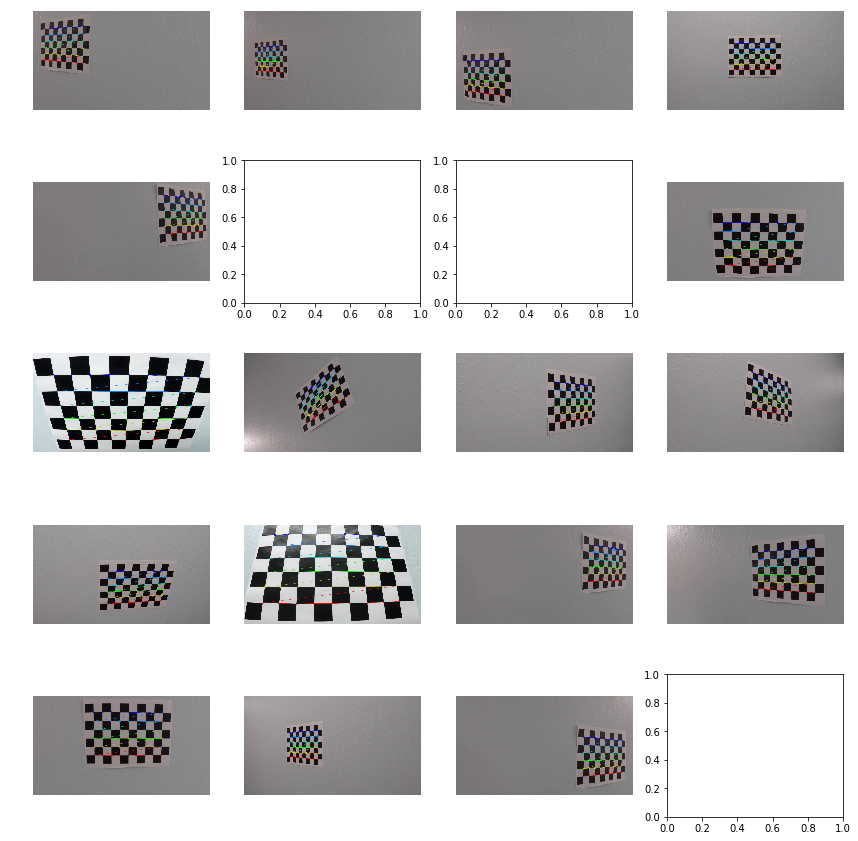

In [7]:
# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9, 0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('camera_cal/calibration*.jpg')

fig, ax = plt.subplots(5,4)
fig.subplots_adjust(right=2, top=3)
ax = ax.ravel()

# Step through the list and search for chessboard corners
for idx, fname in enumerate(images):
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6), None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        cv2.drawChessboardCorners(img, (9,6), corners, ret)
        #write_name = 'corners_found'+str(idx)+'.jpg'
        #cv2.imwrite(write_name, img)
        #cv2.imshow('img', img)
        #cv2.waitKey(500)
        ax[idx].axis('off')
        ax[idx].imshow(img)

#cv2.destroyAllWindows()

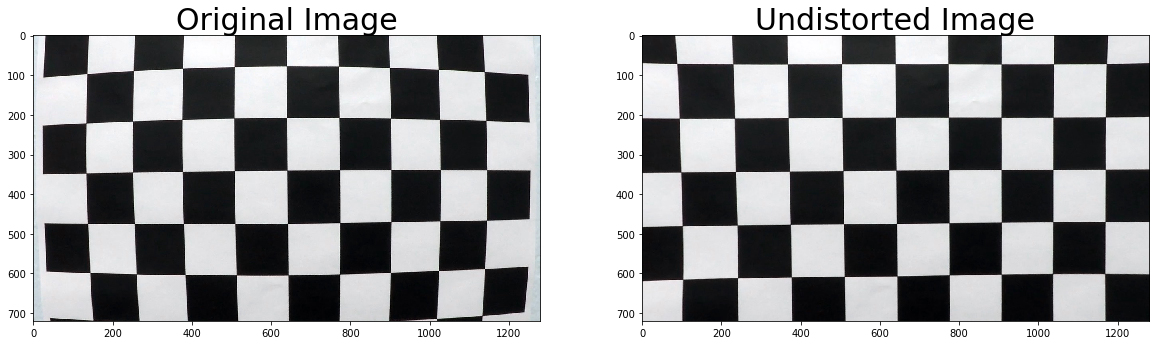

In [15]:
# Test undistortion on an image
img = cv2.imread('camera_cal/calibration1.jpg')
img_size = (img.shape[1], img.shape[0])

# Do camera calibration given object points and image points
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)


dst = cv2.undistort(img, mtx, dist, None, mtx)

# Save the camera calibration result for later use (we won't worry about rvecs / tvecs)
dist_pickle = {}
dist_pickle["mtx"] = mtx
dist_pickle["dist"] = dist
pickle.dump( dist_pickle, open( "calibration_wide.p", "wb" ) )
#dst = cv2.cvtColor(dst, cv2.COLOR_BGR2RGB)
# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(dst)
ax2.set_title('Undistorted Image', fontsize=30)

## Distortion correction on test images

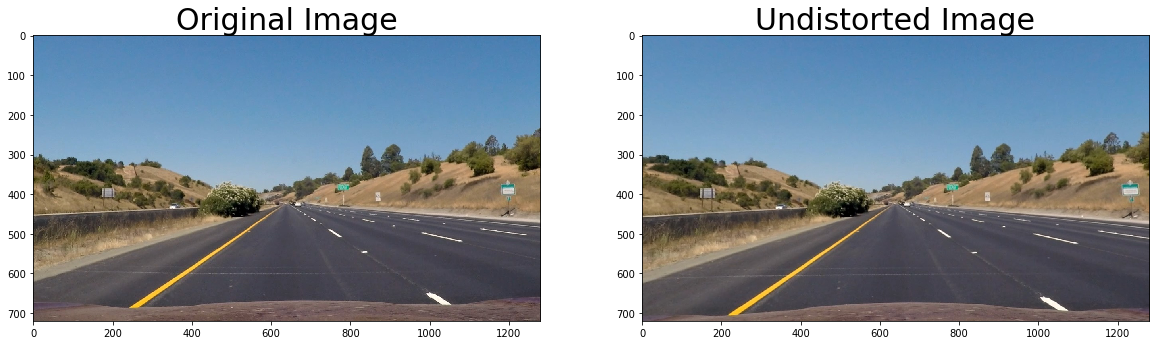

In [19]:
test_images = glob.glob('test_images/*.jpg')
undist_images = []

for idx, fname in enumerate(test_images):
    test_img = cv2.cvtColor(cv2.imread(fname), cv2.COLOR_BGR2RGB)
    test_dst = cv2.undistort(test_img, mtx, dist, None, mtx)
    undist_images.append(test_dst)

# Visualize undistortion
test_img1 = cv2.cvtColor(cv2.imread('test_images/straight_lines1.jpg'), cv2.COLOR_BGR2RGB)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(test_img1)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(undist_images[0])
ax2.set_title('Undistorted Image', fontsize=30)

## Create binary image

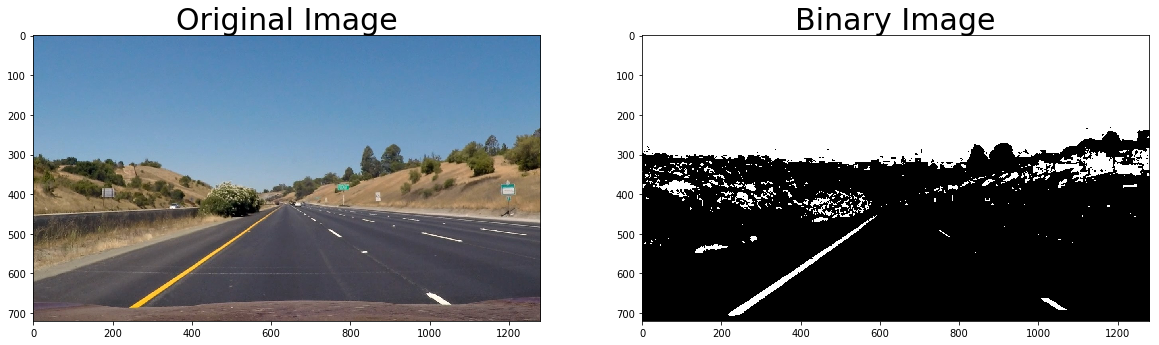

In [22]:
binary_images = []
threshold = (90,255)
for idx, undist_img in enumerate(undist_images):
    img_hls = cv2.cvtColor(undist_img, cv2.COLOR_RGB2HLS)
    s_channel = img_hls[:,:,2]
    binary_img = np.zeros_like(s_channel)
    binary_img[(s_channel > threshold[0]) & (s_channel <= threshold[1])] = 1
    binary_images.append(binary_img)

# Visualize binary image
test_img1 = cv2.cvtColor(cv2.imread('test_images/straight_lines1.jpg'), cv2.COLOR_BGR2RGB)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(test_img1)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(binary_images[0], cmap='gray')
ax2.set_title('Binary Image', fontsize=30)